<a href="https://colab.research.google.com/github/Jeet1309/SOC_mrophix/blob/main/clip2stylegan_base_my_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install essentials
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision

# Clone StyleGAN2-ADA PyTorch (Official NVIDIA repo)
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch

# Download pretrained StyleGAN2 model (FFHQ example)
!mkdir models



In [2]:
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl -P models


--2025-06-25 10:15:49--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 216.137.39.37, 216.137.39.99, 216.137.39.20, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|216.137.39.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘models/ffhq.pkl’

ffhq.pkl            100%[===================>] 363.94M   315MB/s    in 1.2s    

2025-06-25 10:15:51 (315 MB/s) - ‘models/ffhq.pkl’ saved [381624121/381624121]



In [3]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import clip
from PIL import Image
import torchvision.transforms as transforms

In [4]:
import torch
import legacy
import dnnlib

In [5]:
import sys
import os

# Suppress all output temporarily
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr

In [14]:
device = 'cuda'

# Load generator
network_path = 'models/ffhq.pkl'
with open(network_path, 'rb') as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)

# Function to sample latent and generate image
def generate_image(z):
    ws = G.mapping(z, None)
    print(ws.shape)
    img = G.synthesis(ws)
    return img
with HiddenPrints():
# Generate a random image
  z = torch.randn([1, G.z_dim]).to(device)
  ws = G.mapping(z, None)
  img = G.synthesis(ws)
print(ws)


tensor([[[-0.2196, -0.1503, -0.0126,  ..., -0.0098, -0.1478,  1.1249],
         [-0.2196, -0.1503, -0.0126,  ..., -0.0098, -0.1478,  1.1249],
         [-0.2196, -0.1503, -0.0126,  ..., -0.0098, -0.1478,  1.1249],
         ...,
         [-0.2196, -0.1503, -0.0126,  ..., -0.0098, -0.1478,  1.1249],
         [-0.2196, -0.1503, -0.0126,  ..., -0.0098, -0.1478,  1.1249],
         [-0.2196, -0.1503, -0.0126,  ..., -0.0098, -0.1478,  1.1249]]],
       device='cuda:0')


In [9]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Image Preprocessing
def preprocess_img(img):
    img = (img + 1) * 127.5  # [-1,1] to [0,255]
    img = img.permute(0, 2, 3, 1).squeeze().cpu().numpy().astype('uint8')
    img = Image.fromarray(img)
    return preprocess(img).unsqueeze(0).to(device)

100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 40.7MiB/s]


In [15]:
def show_images(before, after=None):
    before = preprocess_img(before).squeeze().permute(1,2,0).cpu().numpy()
    after = preprocess_img(after).squeeze().permute(1,2,0).cpu().numpy()
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(before)
    ax[0].set_title("Original")
    ax[1].imshow(after)
    ax[1].set_title("Edited")
    plt.show()


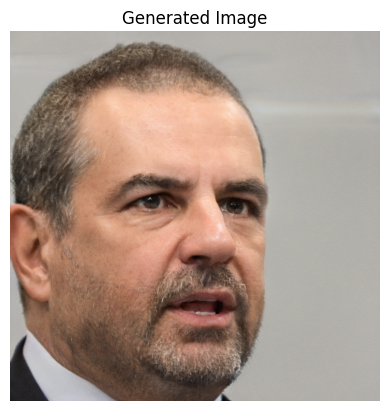

In [16]:
import torch
import torchvision.transforms.functional as TF
img_display = (img.clamp(-1, 1) + 1) / 2
img_pil = TF.to_pil_image(img_display.squeeze(0).cpu())
img_pil.show()
plt.imshow(img_pil)
plt.axis('off')
plt.title('Generated Image')
plt.show()

In [24]:
# Generate N images
N = 20000
latent_dim = G.z_dim
latents = torch.randn([N, latent_dim]).to(device)
clip_features = []

for i in range (len(latents)):
  if((i+1)%1000 == 0):
    print(f"Progress: {i}/{len(latents)}")
    z = latents[i]
    z = z.unsqueeze(0)
    with HiddenPrints():
      img = generate_image(z)
      img_prep = preprocess_img(img)
      with torch.no_grad():
          image_features = clip_model.encode_image(img_prep)
      clip_features.append(image_features.cpu().numpy())




Progress: 999/20000
Progress: 1999/20000
Progress: 2999/20000
Progress: 3999/20000
Progress: 4999/20000
Progress: 5999/20000
Progress: 6999/20000
Progress: 7999/20000
Progress: 8999/20000
Progress: 9999/20000
Progress: 10999/20000
Progress: 11999/20000
Progress: 12999/20000
Progress: 13999/20000
Progress: 14999/20000
Progress: 15999/20000
Progress: 16999/20000
Progress: 17999/20000
Progress: 18999/20000
Progress: 19999/20000


In [25]:
import numpy as np

clip_features = np.vstack(clip_features)


In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)  # find top 10 directions
pca.fit(clip_features)
directions = pca.components_


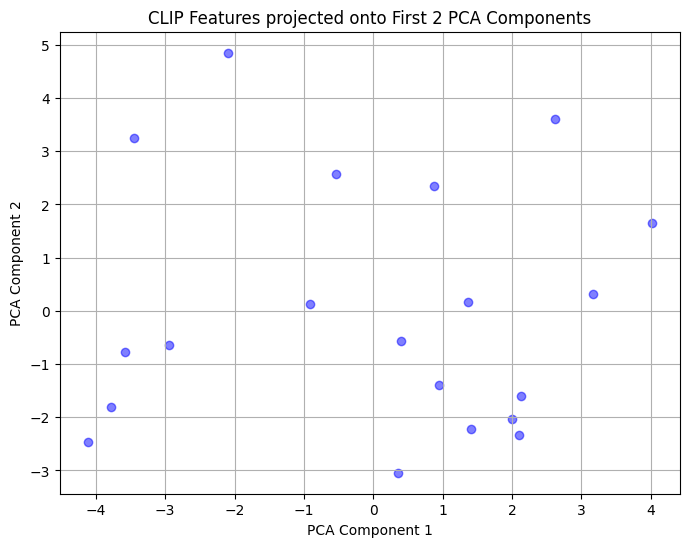

In [27]:
import matplotlib.pyplot as plt

# PCA 2D projection
clip_pca = PCA(n_components=2)
clip_2d = clip_pca.fit_transform(clip_features)

plt.figure(figsize=(8,6))
plt.scatter(clip_2d[:,0], clip_2d[:,1], c='blue', alpha=0.5)
plt.title('CLIP Features projected onto First 2 PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()


In [28]:
text_prompts = ["smiling", "old", "young", "angry", "wearing glasses",
                "blonde hair", "black hair", "man", "woman", "serious"]

text_tokens = clip.tokenize(text_prompts).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens).cpu().numpy()

labels = []
for dir in directions:
    sims = text_features @ dir  # cosine similarity
    best_idx = np.argmax(sims)
    labels.append(text_prompts[best_idx])

print("Discovered Directions + Labels:")
for i, lbl in enumerate(labels):
    print(f"Direction {i+1}: {lbl}")


Discovered Directions + Labels:
Direction 1: smiling
Direction 2: man
Direction 3: wearing glasses
Direction 4: young
Direction 5: black hair
Direction 6: wearing glasses
Direction 7: serious
Direction 8: blonde hair
Direction 9: wearing glasses
Direction 10: woman


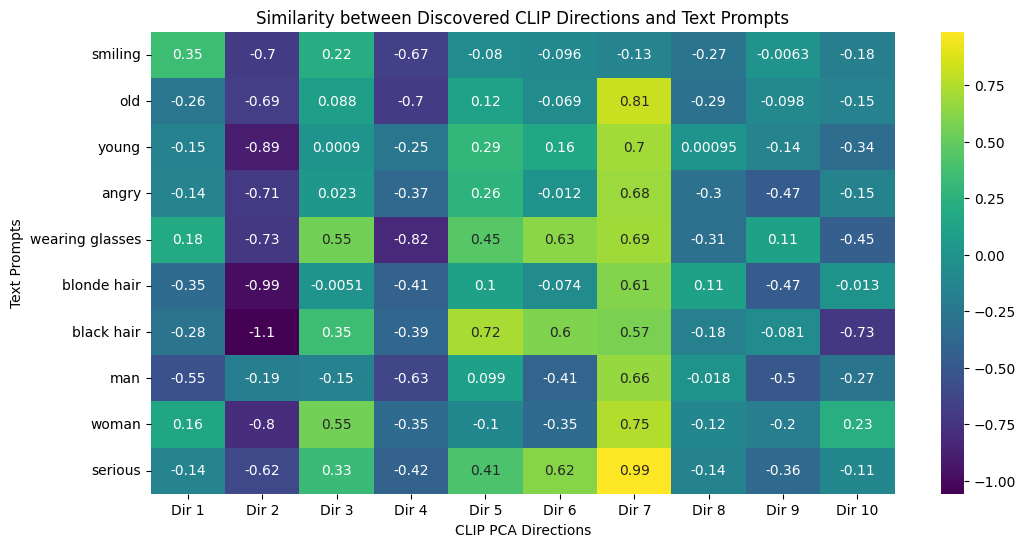

In [29]:
import seaborn as sns

# Compute similarity of directions to text prompts
sims = np.dot(text_features, directions.T)

plt.figure(figsize=(12,6))
sns.heatmap(sims, xticklabels=[f'Dir {i+1}' for i in range(directions.shape[0])],
            yticklabels=text_prompts, annot=True, cmap='viridis')
plt.title('Similarity between Discovered CLIP Directions and Text Prompts')
plt.xlabel('CLIP PCA Directions')
plt.ylabel('Text Prompts')
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression

# Get latent vectors used to generate the images
w_latents = G.mapping(latents, None).detach().cpu().numpy().squeeze()
w_latents_flat = w_latents.reshape(w_latents.shape[0], -1)  # [N, 18*512]

# Map PCA directions back to W space
regressors = []
for i in range(directions.shape[0]):
    target = clip_features @ directions[i]  # shape: [N]
    reg = LinearRegression().fit(w_latents_flat, target)
    regressors.append(reg.coef_)  # shape: [18*512]


# regressors[i] gives latent direction corresponding to CLIP direction i


In [ ]:
def edit_image(z, direction_idx, alpha):
    w = G.mapping(z, None)
    edit_direction = torch.tensor(regressors[0].reshape(18, 512)).to(device)


    w = w + alpha * edit_direction  # move along the direction
    img = G.synthesis(w)
    return img

# Example edit
with HiddenPrints():
  z = torch.randn([1, latent_dim]).to(device)
  img = edit_image(z, direction_idx=0, alpha=5)  # 0 = first discovered direction


In [ ]:
import matplotlib.pyplot as plt

def show_images(before, after):
    before = preprocess_img(before).squeeze().permute(1,2,0).cpu().numpy()
    after = preprocess_img(after).squeeze().permute(1,2,0).cpu().numpy()
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(before)
    ax[0].set_title("Original")
    ax[1].imshow(after)
    ax[1].set_title("Edited")
    plt.show()

z = torch.randn([1, latent_dim]).to(device)
before = generate_image(z)
after = edit_image(z, direction_idx=4, alpha=10)
show_images(before, after)


In [ ]:
z = torch.randn([1, latent_dim]).to(device)


In [ ]:

before = generate_image(z)
weight = [5,10,15,20,25,35,50]
afters =[]
for i in weight:
  after = edit_image(z, direction_idx=2, alpha=i)
  afters.append(after)



In [ ]:
import torch
import torchvision.transforms.functional as TF

def undo_clip_preprocessing(tensor_img):
    """
    Reverses the preprocessing applied for CLIP.

    Args:
        tensor_img: A torch.Tensor image of shape [3, H, W], normalized for CLIP.

    Returns:
        A torch.Tensor image in [0,1] suitable for visualization.
    """
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(-1, 1, 1)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(-1, 1, 1)

    img = tensor_img.clone().detach().cpu()
    img = img * std + mean  # Denormalize
    img = img.clamp(0, 1)   # Ensure values are in [0, 1] for visualization

    return img


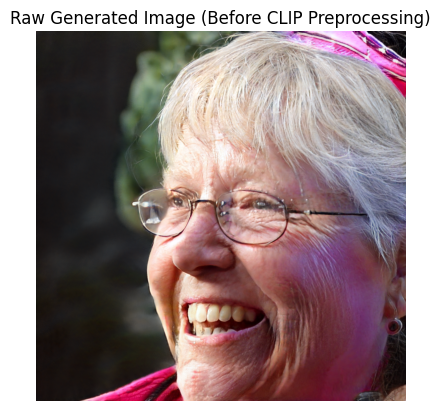

direction 2 weight 5


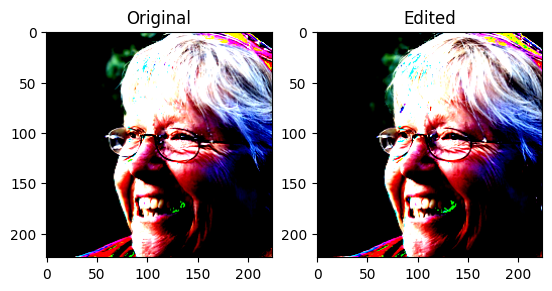

direction 2 weight 10


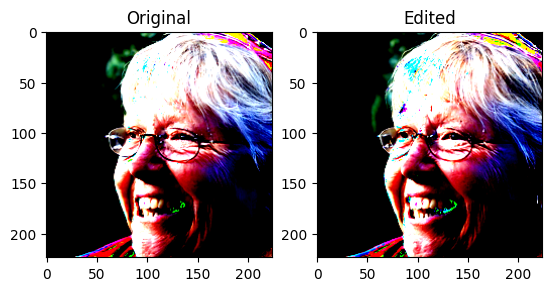

direction 2 weight 15


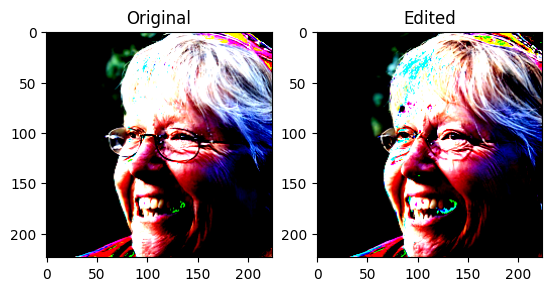

direction 2 weight 20


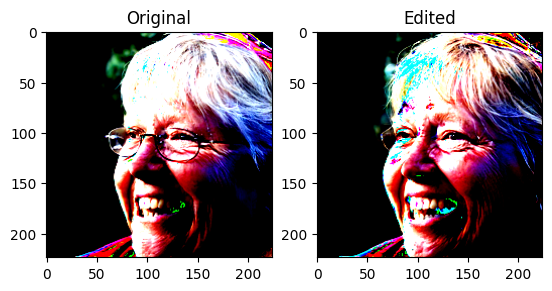

direction 2 weight 25


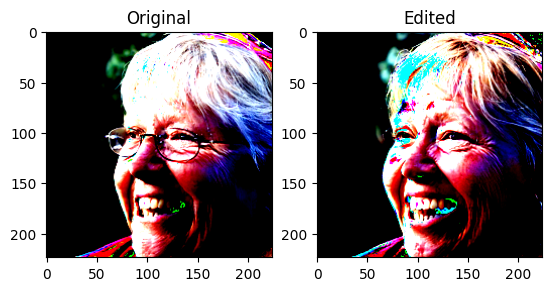

In [ ]:
import torchvision.transforms.functional as TF
img_display = (before.clamp(-1, 1) + 1) / 2  # Now in range [0, 1]

# Convert to PIL Image for display
img_pil = TF.to_pil_image(img_display.squeeze(0).cpu())

# Display
img_pil.show()
plt.imshow(img_pil)
plt.axis('off')
plt.title('Raw Generated Image (Before CLIP Preprocessing)')
plt.show()
for i in range(5):
  print(f"direction 2 weight {weight[i]}")
  show_images(before,afters[i])

In [ ]:
regressors[0].shape == (18*512,)  # flattened during fitting


True

In [ ]:
edit_direction = regressors[i].reshape(18, 512)


In [ ]:
z = torch.randn([1, latent_dim]).to(device)

In [ ]:
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

# Your discovered labels for each PCA direction:
text_prompts = [
 'woman',
 'man',
 'woman',
 'woman',
 'smiling',
 'black hair',
 'woman',
 'angry',
 'serious',
 'smiling'
]

# Random latent z:

with HiddenPrints():

  before = generate_image(z)

  # Range of alpha for editing strength:
  weight = [-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100]

  # Convert original (un-edited) image to displayable format:
  img_display = (before.clamp(-1, 1) + 1) / 2
  img_pil = TF.to_pil_image(img_display.squeeze(0).cpu())


  def edit_image(z, direction_idx, alpha):
      w = G.mapping(z, None)  # shape: [1, 18, 512]
      edit = torch.tensor(regressors[direction_idx].reshape(18, 512)).to(device)
      w_edit = w + alpha * edit
      img = G.synthesis(w_edit)
      return img

  # Loop through all directions and visualize:
  afters = {}
  for dir_idx, prompt in enumerate(text_prompts):
      afters[prompt] = []  # Initialize list for each direction

      for alpha in weight:
          after = edit_image(z, direction_idx=dir_idx, alpha=alpha)
          afters[prompt].append(after)  # store image




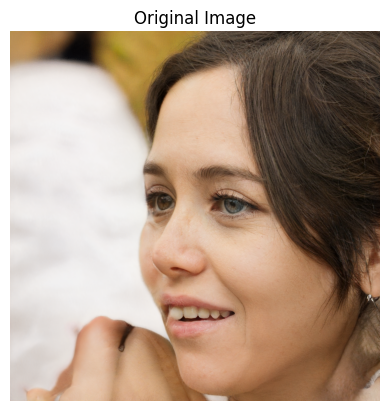

In [ ]:

plt.imshow(img_pil)
plt.axis('off')
plt.title('Original Image')
plt.show()

In [ ]:
import math

max_cols = 4  # Max images per row

for prompt in text_prompts:
    imgs = afters[prompt]  # list of edited images for this direction
    total_imgs = len(imgs) + 1  # +1 for original
    n_cols = min(max_cols, total_imgs)
    n_rows = math.ceil(total_imgs / max_cols)

    plt.figure(figsize=(4 * n_cols, 4 * n_rows))

    # Original image at position 1
    plt.subplot(n_rows, n_cols, 1)
    img_display = (before.clamp(-1, 1) + 1) / 2
    img_pil = TF.to_pil_image(img_display.squeeze(0).cpu())
    plt.imshow(img_pil)
    plt.axis('off')
    plt.title('Original')

    # Edited versions
    for i, after in enumerate(imgs):
        after_display = (after.clamp(-1, 1) + 1) / 2
        after_pil = TF.to_pil_image(after_display.squeeze(0).cpu())

        plt.subplot(n_rows, n_cols, i + 2)  # start from position 2
        plt.imshow(after_pil)
        plt.axis('off')
        plt.title(f'α={weight[i]}')

    plt.suptitle(f'Editing along: {prompt}', fontsize=16)
    plt.tight_layout()
    plt.show()

